In [1]:
import pickle
import sys
sys.path.insert(1, '../src/siamese_triplet')

In [2]:
import matplotlib as plt
%matplotlib inline
import numpy as np 
import pandas as pd 
import torch
import torchtext
from torchtext import data
import spacy
import os

spacy_en = spacy.load('en')
SEED = 1234


In [3]:
TEXT = data.Field(lower=True,include_lengths=False, tokenize = 'spacy')

LABEL = data.Field( dtype = torch.int)

dataFields = {'content': ('content', TEXT), 
              'author_label': ('author_label', LABEL)}

In [4]:
data_dir = '../data/processed/'
data_name = 'longest_poems.json'

In [5]:
dataset= data.TabularDataset(path=data_dir+data_name, 
                                            format='json',
                                            fields=dataFields, 
                                            skip_header=True)

In [102]:
len(dataset)

675

In [6]:
import random
SEED = 3
train_data, valid_data = dataset.split(split_ratio=0.8,random_state = random.seed(SEED))



In [7]:
' '.join(train_data.examples[0].content)

'o. \n yes , yes that and \n the other \n and this and that and more and all \n and the other and o yes \n all yes all yes , all yes . \n touch me . \n i remember . \n \n scene five \n  nicholas alone . he now has two prosthetic arms and a prosthetic leg , but glides about efficiently , as though he has become part segway . he is fiddling with the now more elaborate bird and portrait , which seem more alive than ever , as does the entire room . robots are bustling about to assist him . miranda enters , apparently accustomed to this new , stranger atmosphere . \n miranda \n they are here \n the important delegation \n from the united way , \n the administration \n and the united nations \n they want to speak to him , they say \n they want his ear .'

In [8]:
MAX_VOCAB_SIZE = 20_000

TEXT.build_vocab(dataset, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

In [9]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

import matplotlib.pyplot as plt
%matplotlib inline

### New way tokenizing and batching

In [10]:
import spacy
nlp = spacy.load('en')

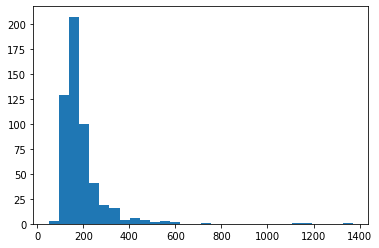

In [11]:
len_train = [len(i.content) for i in train_data.examples]
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(len_train,bins=30)
plt.show()

In [12]:
def pad_to_n(ls, n ):
    ls= ls[:n]
    if len(ls)<n: ls=(['<pad>']*(n-len(ls))) + ls
    return ls

In [13]:
def token2index(tokenized):
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]    
    tensor = torch.LongTensor(indexed)#.to(device)
    #tensor = tensor.unsqueeze(1) 
    #Note for the future: outmost sigmoid was included as part of the loss function
    return tensor

In [14]:
FIX_TEXT_LENGTH = 101
def to_Loader(data,labels):
    data = [pad_to_n(i, FIX_TEXT_LENGTH) for i in data]
    data = [token2index(i) for i in data]
    data = torch.stack(data)
        
    #labels= [(lambda y: 1 if y=='pos' else 0)(i) for i in labels]
    labels= torch.Tensor(labels)
    return data, labels

In [15]:
training_data_list = [i.content for i in train_data.examples]
training_labels_list = [i.author_label for i in train_data.examples]
training_data, training_labels= to_Loader(training_data_list, training_labels_list)

In [16]:
from datasets import BalancedBatchSampler
train_batch_sampler = BalancedBatchSampler(training_labels, n_classes=10, n_samples=10)
training_tensordataset = torch.utils.data.TensorDataset(training_data, training_labels)
training_Loader=torch.utils.data.DataLoader(training_tensordataset, sampler=train_batch_sampler)

In [17]:
validating_data_list = [i.content for i in valid_data.examples]
validating_labels_list = [i.author_label for i in valid_data.examples]
validating_data, validating_labels= to_Loader(validating_data_list, validating_labels_list)

In [18]:
valid_batch_sampler = BalancedBatchSampler(validating_labels, n_classes=10, n_samples=2)
validating_tensordataset = torch.utils.data.TensorDataset(validating_data, validating_labels)
validating_Loader=torch.utils.data.DataLoader(validating_tensordataset,batch_size=64)

In [19]:
next(iter(valid_batch_sampler))

[90,
 12,
 14,
 1,
 101,
 16,
 18,
 128,
 39,
 85,
 67,
 74,
 108,
 95,
 8,
 83,
 70,
 105,
 111,
 62]

In [20]:
validating_data[0]

tensor([   96,    42,    20,  4160,     3,    12,  4656,  1709,     2,    14,
         1133,   837,     3,    21,     4,   395,    20,  1022,     3,     2,
          250,   378,     4,   525,   739,     9,    99,   145,     6,     2,
          240,    49,     4,  1613,    44,    31,   903,  3087,     2,    80,
            4,   586,   275,     8,   933,    32,    57,     3,     2,   254,
            8,  1000,    11,   163,   694,    15,  3561,     3,     2,     5,
          356,    21,    99,  1046,     4,  6604,   138,     3,     2,   123,
            7, 12398,     4,   837,    27,  7317,     6,     2,    15,    49,
            7,    22,   274,     4,  2242,  2020,     2,   396, 10671,     7,
           63,     3,    38,  2343,     7,   294,     3,     2,    19,   380,
            7])

In [21]:
validating_labels[2]

tensor(2.)

In [22]:
validating_Loader.dataset[0]

(tensor([   96,    42,    20,  4160,     3,    12,  4656,  1709,     2,    14,
          1133,   837,     3,    21,     4,   395,    20,  1022,     3,     2,
           250,   378,     4,   525,   739,     9,    99,   145,     6,     2,
           240,    49,     4,  1613,    44,    31,   903,  3087,     2,    80,
             4,   586,   275,     8,   933,    32,    57,     3,     2,   254,
             8,  1000,    11,   163,   694,    15,  3561,     3,     2,     5,
           356,    21,    99,  1046,     4,  6604,   138,     3,     2,   123,
             7, 12398,     4,   837,    27,  7317,     6,     2,    15,    49,
             7,    22,   274,     4,  2242,  2020,     2,   396, 10671,     7,
            63,     3,    38,  2343,     7,   294,     3,     2,    19,   380,
             7]), tensor(1.))

In [23]:
i=0
for i,_ in enumerate(training_Loader):
    i+=1
print(i)

5


## Plotting function

In [114]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
    
def extract_embeddings(dataloader, model, emb_dim):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), emb_dim))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for poems, target in dataloader:
            poems = poems.squeeze()
            poems_le= len(poems)
            if cuda:
                poems = poems.cuda()

            embeddings[k:k+poems_le] = model.get_embedding(poems).data.cpu().numpy()
            
            labels[k:k+poems_le] = target.numpy()
            k += poems_le
    return embeddings, labels

def plot_embeddings(embeddings, targets, xlim=None, ylim=None,  save_plot= None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)
    if save_plot!=None:
        plt.savefig('../images/'+save_plot)

In [25]:
#train_embeddings_otl, train_labels_otl = extract_embeddings(training_Loader, MODEL,2)

## Build the Model



In [26]:
sys.path.insert(1, '../src/')
from models import FastText, CNN

In [94]:
INPUT_DIM = len(TEXT.vocab)
WORD_EMBEDDING_DIM = 100 #Fixed by preloaded embedding 

AUTHOR_DIM = 2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model = FastText(INPUT_DIM, WORD_EMBEDDING_DIM, AUTHOR_DIM, PAD_IDX)


INPUT_DIM = len(TEXT.vocab)
WORD_EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
AUTHOR_DIM = 2
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, WORD_EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, AUTHOR_DIM, DROPOUT, PAD_IDX)


pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

model.embedding.weight.data[UNK_IDX] = torch.zeros(WORD_EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(WORD_EMBEDDING_DIM)

In [95]:
# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric


import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()


MARGIN = 0.20
embedding_net = EmbeddingNet()

#embedding_net = CNN_net # Uncomment to comeback to original version 
#MODEL = embedding_net
MODEL= model
if cuda:
    MODEL.cuda()
loss_fn = OnlineTripletLoss(MARGIN, RandomNegativeTripletSelector(MARGIN))
LR = 5e-3 
optimizer = optim.Adam(MODEL.parameters(), lr=LR, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
log_interval = 4

In [96]:
fit(training_Loader, training_Loader, MODEL, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/540 (0%)]	Loss: 0.666573	Average nonzero triplets: 450.0
Train: [400/540 (80%)]	Loss: 0.554447	Average nonzero triplets: 450.0
Epoch: 1/10. Train set: Average loss: 0.5769	Average nonzero triplets: 450.0
Epoch: 1/10. Validation set: Average loss: 0.1869	Average nonzero triplets: 450.0
Train: [0/540 (0%)]	Loss: 0.472720	Average nonzero triplets: 450.0
Train: [400/540 (80%)]	Loss: 0.383829	Average nonzero triplets: 450.0
Epoch: 2/10. Train set: Average loss: 0.4016	Average nonzero triplets: 450.0
Epoch: 2/10. Validation set: Average loss: 0.1772	Average nonzero triplets: 450.0
Train: [0/540 (0%)]	Loss: 0.317260	Average nonzero triplets: 450.0
Train: [400/540 (80%)]	Loss: 0.277437	Average nonzero triplets: 449.6
Epoch: 3/10. Train set: Average loss: 0.2854	Average nonzero triplets: 449.6
Epoch: 3/10. Validation set: Average loss: 0.1634	Average nonzero triplets: 450.0
Train: [0/540 (0%)]	Loss: 0.235800	Average nonzero triplets: 450.0
Train: [400/540 (80%)]	Loss: 0.211771	Average

# Plotting time

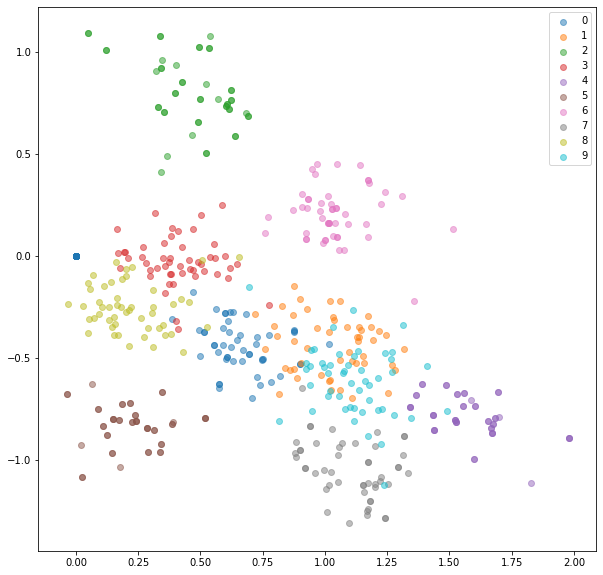

In [119]:
train_embeddings_otl, train_labels_otl = extract_embeddings(training_Loader, MODEL, AUTHOR_DIM)
plot_embeddings(train_embeddings_otl, train_labels_otl, save_plot='training.png')

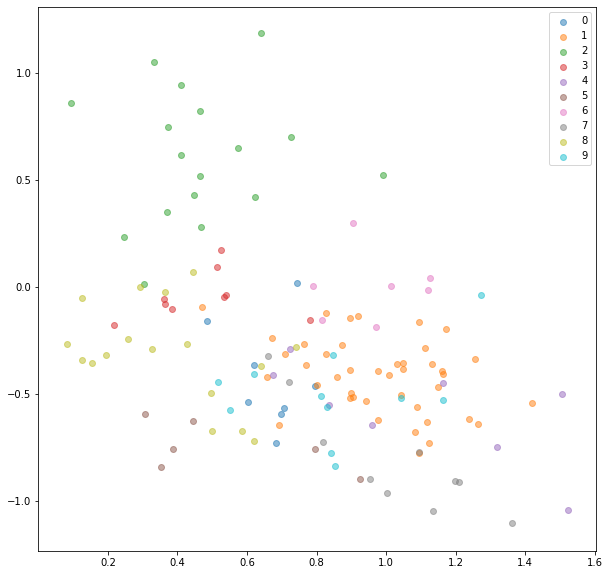

In [120]:
valid_embeddings_otl, valid_labels_otl = extract_embeddings(validating_Loader, MODEL, AUTHOR_DIM)
plot_embeddings(valid_embeddings_otl, valid_labels_otl,save_plot='testing.png')

In [99]:
from sklearn.neighbors import KNeighborsClassifier as KNC
KNN = KNC(n_neighbors=3)
KNN.fit(train_embeddings_otl, train_labels_otl)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [100]:
predictions= KNN.predict(valid_embeddings_otl)
predictions

array([0., 1., 2., 0., 6., 9., 4., 6., 2., 0., 2., 7., 7., 8., 9., 1., 0.,
       9., 6., 2., 6., 1., 0., 7., 1., 9., 1., 8., 7., 1., 1., 2., 9., 9.,
       1., 3., 1., 0., 5., 0., 3., 2., 2., 2., 0., 7., 0., 3., 9., 2., 0.,
       3., 3., 7., 1., 4., 8., 0., 8., 9., 1., 9., 5., 1., 2., 5., 0., 3.,
       9., 0., 1., 9., 1., 1., 3., 1., 1., 3., 1., 2., 0., 1., 0., 3., 3.,
       8., 0., 0., 6., 7., 7., 9., 0., 9., 4., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 8., 0., 8., 6., 9., 9., 3., 5., 2., 9., 1., 0., 1., 1., 3.,
       6., 3., 2., 8., 0., 3., 1., 3., 1., 1., 0., 0., 1., 8., 1., 0.])

In [101]:
KNN.score(valid_embeddings_otl,valid_labels_otl)

0.5407407407407407